<h1><center>Sales Analysis<center><h1>

<h1><center>Import the required libraries and foundational code</center></h1>

In [28]:
# Load libraries for analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
import warnings


In [4]:
# This code standardizes illustrations
plt.rcParams['figure.figsize'] = [10,8]
plt.rc('axes', titlesize= 20, labelsize =15)
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'serif' # Example: change font family

In [5]:
# ignores supplemental warnings
warnings.filterwarnings('ignore')

<h1><center>Load data and perform feature engineerig</center></h1>

In [6]:
# Load data and display dataframe.
sales = pd.read_csv('sales_data.csv')
sales

,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
0,1052,2023-02-03,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
1,1093,2023-04-21,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2,1015,2023-09-21,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
3,1072,2023-08-24,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
4,1061,2023-03-24,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1010,2023-04-15,Charlie,North,4733.88,4,Food,4943.03,5442.15,Returning,0.29,Cash,Online,North-Charlie
996,1067,2023-09-07,Bob,North,4716.36,37,Clothing,1754.32,1856.40,New,0.21,Bank Transfer,Retail,North-Bob
997,1018,2023-04-27,David,South,7629.70,17,Clothing,355.72,438.27,Returning,0.06,Bank Transfer,Online,South-David
998,1100,2023-12-20,David,West,1629.47,39,Electronics,3685.03,3743.39,New,0.01,Bank Transfer,Online,West-David


In [7]:
# Display shape of the data frame.
print("The dimension of the data frame is:", sales.shape)

The dimension of the data frame is: (1000, 14)


In [8]:
# Display data types.
print("The data types in the data frame are:\n", sales.dtypes)

The data types in the data frame are:
 Product_ID                int64
Sale_Date                object
Sales_Rep                object
Region                   object
Sales_Amount            float64
Quantity_Sold             int64
Product_Category         object
Unit_Cost               float64
Unit_Price              float64
Customer_Type            object
Discount                float64
Payment_Method           object
Sales_Channel            object
Region_and_Sales_Rep     object
dtype: object


In [9]:
# Convert Sale Date column from object to time stamp.
sales['Sale_Date'] = pd.to_datetime(sales['Sale_Date']) 
sales['Sale_Date'].dtype

dtype('<M8[ns]')

In [10]:
# Convert sales date from a column to an index and display new data frame.
sales_t = sales.set_index('Sale_Date')
sales_t.head()

,Product_ID,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
Sale_Date,,,,,,,,,,,,,
2023-02-03,1052,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
2023-04-21,1093,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2023-09-21,1015,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
2023-08-24,1072,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
2023-03-24,1061,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


In [11]:
# Drop redundant column
sales_t.drop(columns='Region_and_Sales_Rep', inplace=True)

In [12]:
# Create a new column to display the net price of the products
sales_t['Net_Price'] = sales_t['Unit_Price']-sales_t['Discount']

In [13]:
# Found a discrepency in Sales Amount column and recalculated based 
# on net price and quantity sold.
sales_t['Profit'] = sales_t['Net_Price'] * sales_t['Quantity_Sold']

In [14]:
# Created a total cost column.
sales_t['Total_Cost']= sales_t['Unit_Cost'] * sales_t['Quantity_Sold']

In [15]:
# Drop sales amount column 
sales_t = sales_t.drop(columns='Sales_Amount')

In [16]:
# Display dataframe with new features.
sales_t.head()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-02-03,1052,Bob,North,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,267.13,4808.34,2749.50
2023-04-21,1093,Bob,West,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,4209.33,71558.61,64878.63
2023-09-21,1015,David,South,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,371.20,11136.00,7846.80
2023-08-24,1072,Bob,South,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,4467.73,174241.47,168871.17
2023-03-24,1061,Charlie,East,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,692.63,9004.19,8285.81


In [17]:
sales_t.dtypes

Product_ID            int64
Sales_Rep            object
Region               object
Quantity_Sold         int64
Product_Category     object
Unit_Cost           float64
Unit_Price          float64
Customer_Type        object
Discount            float64
Payment_Method       object
Sales_Channel        object
Net_Price           float64
Profit              float64
Total_Cost          float64
dtype: object

In [18]:
salesOne_hot_encoding = pd.get_dummies(sales_t).replace({True:1, False:0})

In [19]:
salesOne_hot_encoding.head()

,Product_ID,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Net_Price,Profit,Total_Cost,Sales_Rep_Alice,Sales_Rep_Bob,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
Sale_Date,,,,,,,,,,,,,,,,,,,,,
2023-02-03,1052,18,152.75,267.22,0.09,267.13,4808.34,2749.50,0,1,...,0,0,1,0,1,0,1,0,1,0
2023-04-21,1093,17,3816.39,4209.44,0.11,4209.33,71558.61,64878.63,0,1,...,0,0,1,0,1,0,1,0,0,1
2023-09-21,1015,30,261.56,371.40,0.20,371.20,11136.00,7846.80,0,0,...,0,1,0,0,1,1,0,0,0,1
2023-08-24,1072,39,4330.03,4467.75,0.02,4467.73,174241.47,168871.17,0,1,...,0,0,0,1,0,0,0,1,0,1
2023-03-24,1061,13,637.37,692.71,0.08,692.63,9004.19,8285.81,0,0,...,1,0,0,1,0,0,0,1,1,0


<h1><center> Visualize data to find seasonality and trends </center></h1>

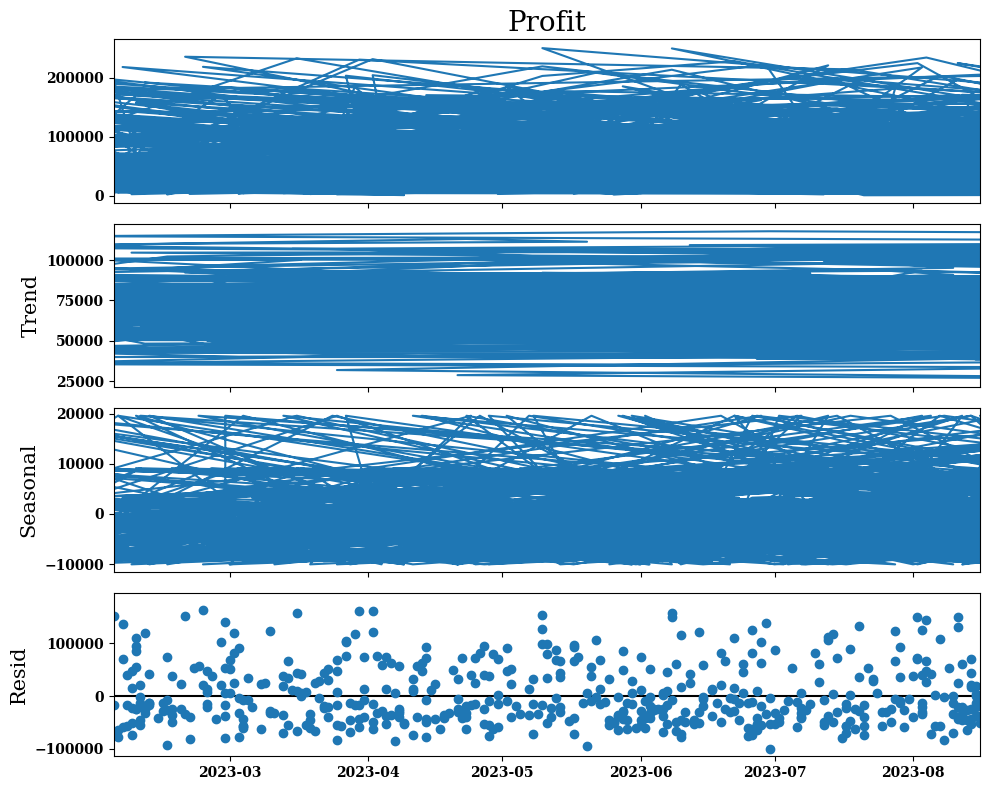

In [ ]:
# Check profit for seasonality.
decomposition = seasonal_decompose(sales_t['Profit'],
                                   model ='add',
                                   period=12)
fig= decomposition.plot()
plt.show()

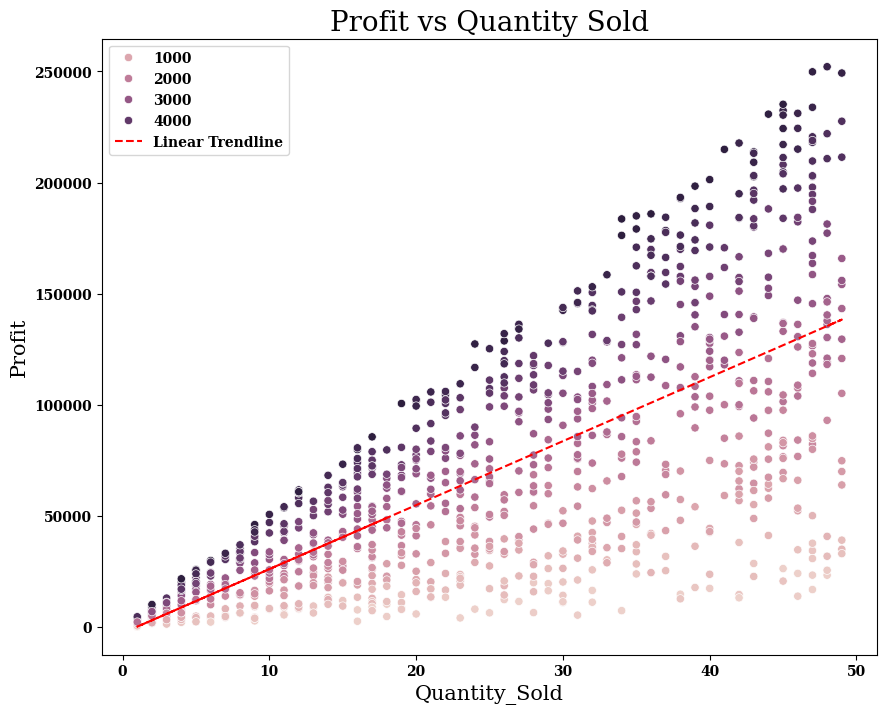

In [21]:
# scatter plot showing a positive trend with profit and quantity sold.
sns.scatterplot(data=salesOne_hot_encoding, x='Quantity_Sold', y='Profit', hue='Unit_Cost')
z = np.polyfit(salesOne_hot_encoding['Quantity_Sold'], salesOne_hot_encoding['Profit'], 1)
p = np.poly1d(z)
plt.plot(salesOne_hot_encoding['Quantity_Sold'], p(salesOne_hot_encoding['Quantity_Sold']), "r--", label="Linear Trendline")
plt.title('Profit vs Quantity Sold')
plt.legend()
plt.show()

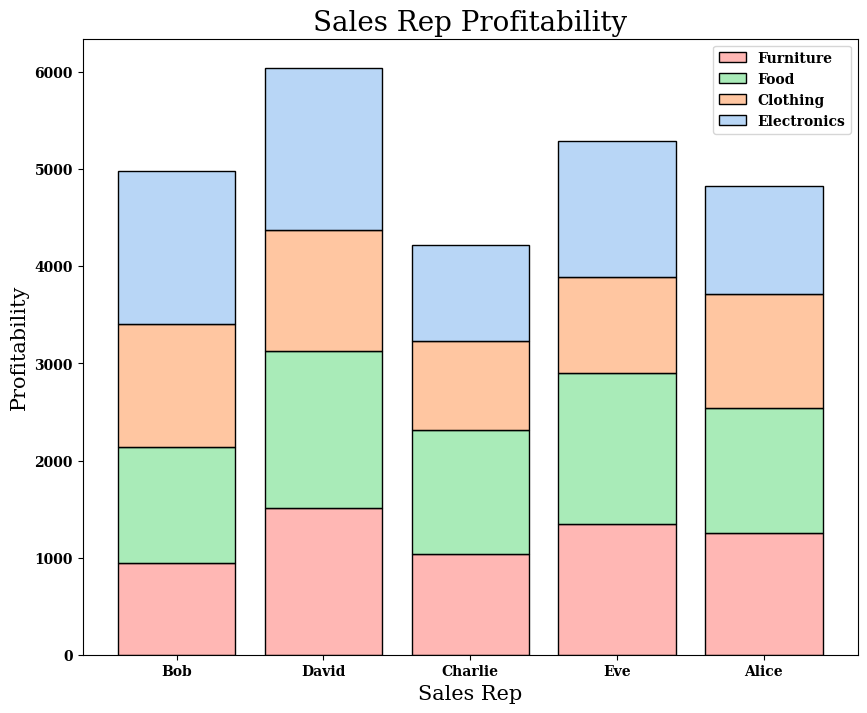

In [22]:
# Stacked barplot outlining the products sold by sales rep.
color_map = ('Furniture', 'Food', 'Clothing', 'Electronics')
sns.histplot(data=sales_t, x='Sales_Rep',weights='Quantity_Sold', 
             hue='Product_Category', multiple='stack',shrink=0.8, palette='pastel')
plt.title('Sales Rep Profitability')
plt.xlabel('Sales Rep')
plt.ylabel('Profitability')
plt.legend(color_map)
plt.show()

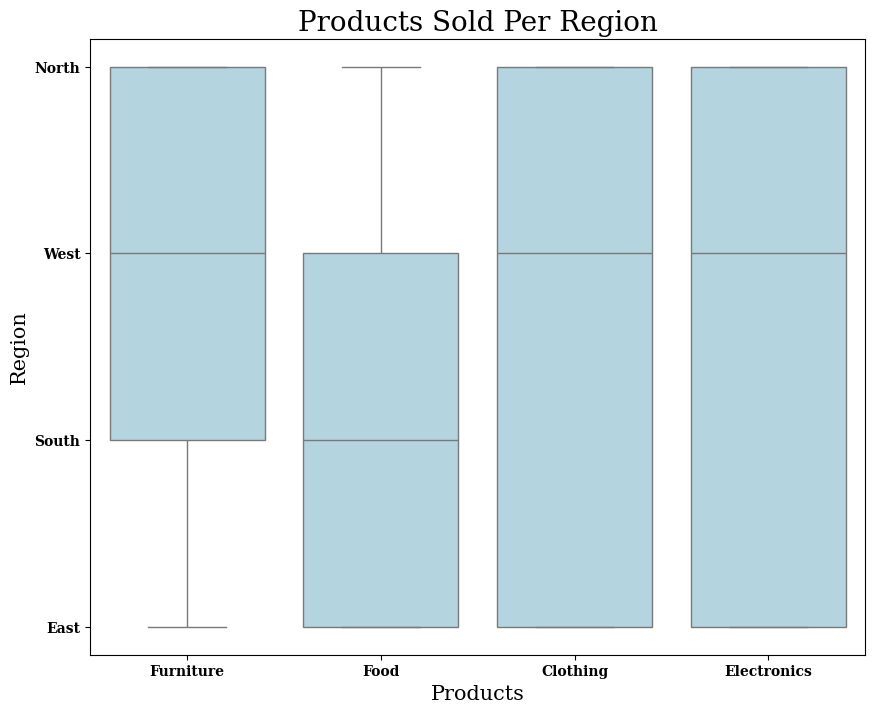

In [23]:
# box plot to compare products sold per region.
sns.boxplot(data=sales_t, x='Product_Category', y= 'Region', color='lightblue')
plt.title('Products Sold Per Region')
plt.xlabel('Products')
plt.ylabel('Region')
plt.show()

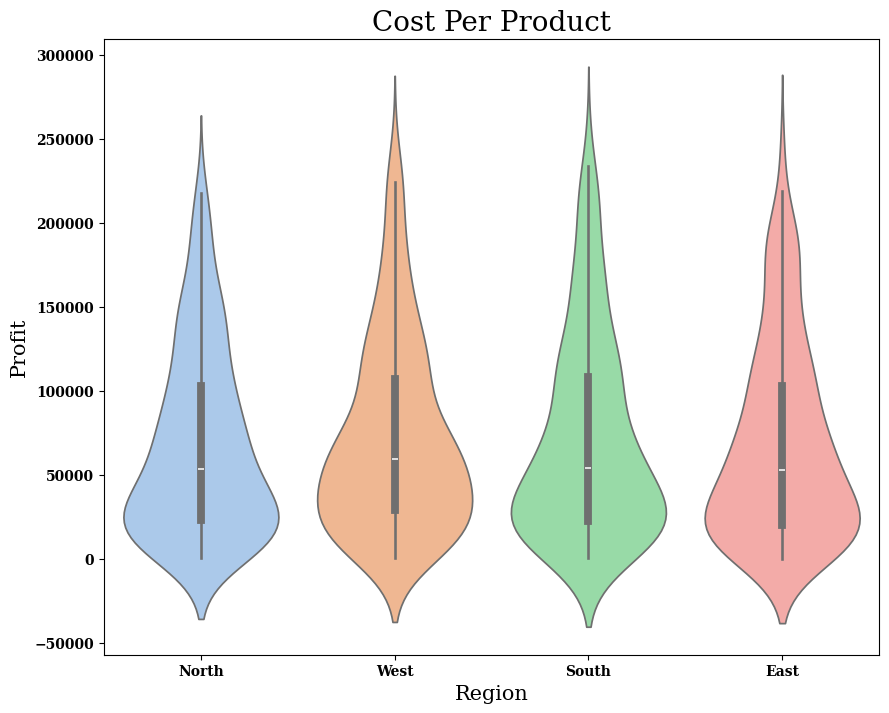

In [24]:
sns.violinplot(data=sales_t, x='Region', y='Profit', palette='pastel')
plt.title('Cost Per Product')
plt.xlabel('Region')
plt.ylabel('Profit')

plt.show()


In [30]:
result =adfuller(sales_t.Profit)
print('p-value: %f' % result[1])

if result[1]<0.5:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary")

p-value: 0.000000
Evidence suggests that the time series is stationary.
